#Testing the Factors that Determine Student Placement and Building a Machine Learning Model to Predict Student Placement



## Importing the Dataset and Cleaning the Data

### Dataset
The dataset that will be used was obtained from the following:

Islam, S. (2025, July). College Student Placement Factors Dataset. Retrieved 12 August 2025 from https://www.kaggle.com/datasets/sahilislam007/college-student-placement-factors-dataset?select=college_student_placement_dataset.csv.

The dataset contains the following information:


1.   College_ID - Unique ID for the college
2.   IQ - IQ score of the student
3.   Prev_Sem_Result - GPA of the previous semester
4.   CGPA	- Cumulative Grade Point Average (range: ~5.0 to 10.0)
5.   Academic_Performance	- Annual academic rating (scale: 1 to 10)
6.   Internship_Experience - Whether the student has completed any internship
7.   Extra_Curricular_Score	Involvement in extracurriculars (score from 0 to 10)
8.   Communication_Skills	- Soft skill rating (scale: 1 to 10)
9.   Projects_Completed	- Number of academic/technical projects completed (0 to 5)
10.  Placement - Final placement result (Yes = Placed, No = Not Placed)

In [1]:
#Importing all the libraries that will be required for this project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import kagglehub

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
#Reading the dataset using the pandas and url

path = kagglehub.dataset_download('sahilislam007/college-student-placement-factors-dataset', 'college_student_placement_dataset.csv')
df = pd.read_csv(path)

df.head()

100%|██████████| 354k/354k [00:00<00:00, 2.72MB/s]


,College_ID,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Internship_Experience,Extra_Curricular_Score,Communication_Skills,Projects_Completed,Placement
0,CLG0030,107,6.61,6.28,8,No,8,8,4,No
1,CLG0061,97,5.52,5.37,8,No,7,8,0,No
2,CLG0036,109,5.36,5.83,9,No,3,1,1,No
3,CLG0055,122,5.47,5.75,6,Yes,1,6,1,No
4,CLG0004,96,7.91,7.69,7,No,8,10,2,No


In [3]:
#Check and sort for any null values
df.isnull().sum()

,0
College_ID,0
IQ,0
Prev_Sem_Result,0
CGPA,0
Academic_Performance,0
Internship_Experience,0
Extra_Curricular_Score,0
Communication_Skills,0
Projects_Completed,0
Placement,0


In [4]:
#Check and sort for any duplicated values
df.duplicated().sum()

np.int64(0)

In [5]:
#Checking for objects that need to be converted from object to numerical for analysis
df.dtypes

,0
College_ID,object
IQ,int64
Prev_Sem_Result,float64
CGPA,float64
Academic_Performance,int64
Internship_Experience,object
Extra_Curricular_Score,int64
Communication_Skills,int64
Projects_Completed,int64
Placement,object


In [6]:
#Using LabelEncoder to convert object features to numeric for analysis

#Initialise Label encoder
le = LabelEncoder()

#Defining the features that need to be converted
categorical_features = ['College_ID', 'Internship_Experience', 'Placement']

#Looping through the features to transform them
for feature in categorical_features:
    df[feature] = le.fit_transform(df[feature])

df.head()

,College_ID,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Internship_Experience,Extra_Curricular_Score,Communication_Skills,Projects_Completed,Placement
0,29,107,6.61,6.28,8,0,8,8,4,0
1,60,97,5.52,5.37,8,0,7,8,0,0
2,35,109,5.36,5.83,9,0,3,1,1,0
3,54,122,5.47,5.75,6,1,1,6,1,0
4,3,96,7.91,7.69,7,0,8,10,2,0


## Exploratory Data Analysis

In [7]:
#Splitting the data into feature set and target set
X = df.drop('Placement', axis=1)
y = df['Placement']

In [8]:
#Descriptive Statistics
df.describe()

,College_ID,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Internship_Experience,Extra_Curricular_Score,Communication_Skills,Projects_Completed,Placement
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,49.70670,99.471800,7.535673,7.532379,5.546400,0.396400,4.970900,5.561800,2.513400,0.165900
std,28.80141,15.053101,1.447519,1.470141,2.873477,0.489174,3.160103,2.900866,1.715959,0.372009
min,0.00000,41.000000,5.000000,4.540000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,25.00000,89.000000,6.290000,6.290000,3.000000,0.000000,2.000000,3.000000,1.000000,0.000000
50%,50.00000,99.000000,7.560000,7.550000,6.000000,0.000000,5.000000,6.000000,3.000000,0.000000
75%,74.00000,110.000000,8.790000,8.770000,8.000000,1.000000,8.000000,8.000000,4.000000,0.000000
max,99.00000,158.000000,10.000000,10.460000,10.000000,1.000000,10.000000,10.000000,5.000000,1.000000


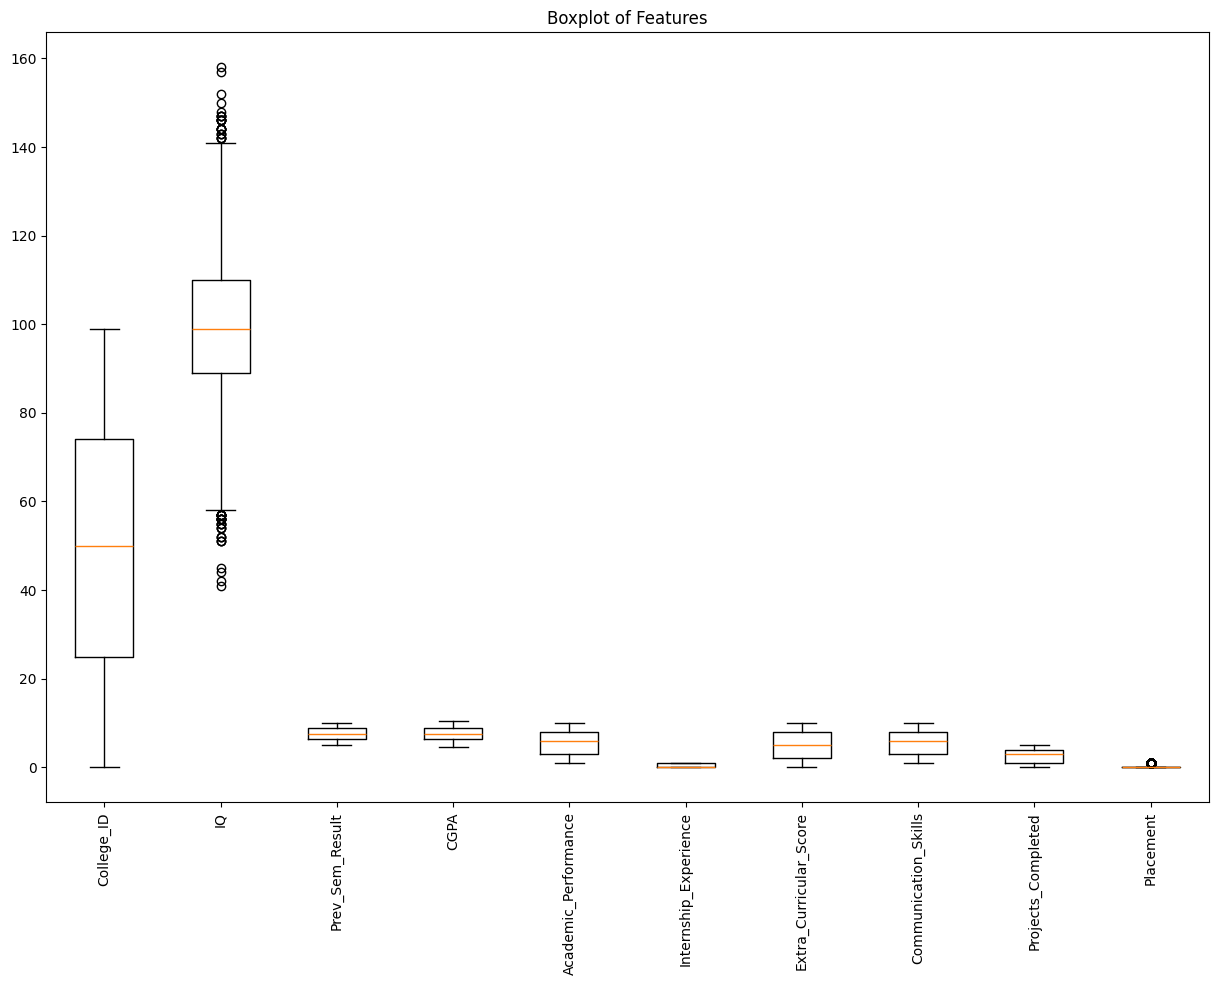

In [9]:
plt.figure(figsize=(15,10))
plt.boxplot(df)
plt.title('Boxplot of Features')
plt.xticks(range(1, len(df.columns) + 1), df.columns, rotation=90)
plt.show()

The boxplots show that there are outliers in the IQ data feature and Placement target variable. These will need to be removed.

In [10]:
#Removing outliers

#Function to remove outliers
def remove_outlier(df, feature):

  #Finding the quartiles and interquartile range of the features
  lq = df[feature].quantile(0.25)
  uq = df[feature].quantile(0.75)
  iqr = uq - lq

  #The upper and lower bounds of the features
  lower_bound = lq - 1.5 * iqr
  upper_bound = uq + 1.5 * iqr

  #Removing the outliers from the dataset
  df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
  return df

#Using the remove outlier function on the 'IQ' and 'Placement' columns
remove_outlier(df, 'IQ')
remove_outlier(df, 'Placement')

,College_ID,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Internship_Experience,Extra_Curricular_Score,Communication_Skills,Projects_Completed,Placement
0,29,107,6.61,6.28,8,0,8,8,4,0
1,60,97,5.52,5.37,8,0,7,8,0,0
2,35,109,5.36,5.83,9,0,3,1,1,0
3,54,122,5.47,5.75,6,1,1,6,1,0
4,3,96,7.91,7.69,7,0,8,10,2,0
...,...,...,...,...,...,...,...,...,...,...
9993,55,77,7.57,7.39,1,1,2,6,3,0
9996,97,70,9.25,9.34,7,0,0,7,2,0
9997,65,89,6.08,6.25,3,1,3,9,5,0
9998,44,107,8.77,8.92,3,0,7,5,1,0


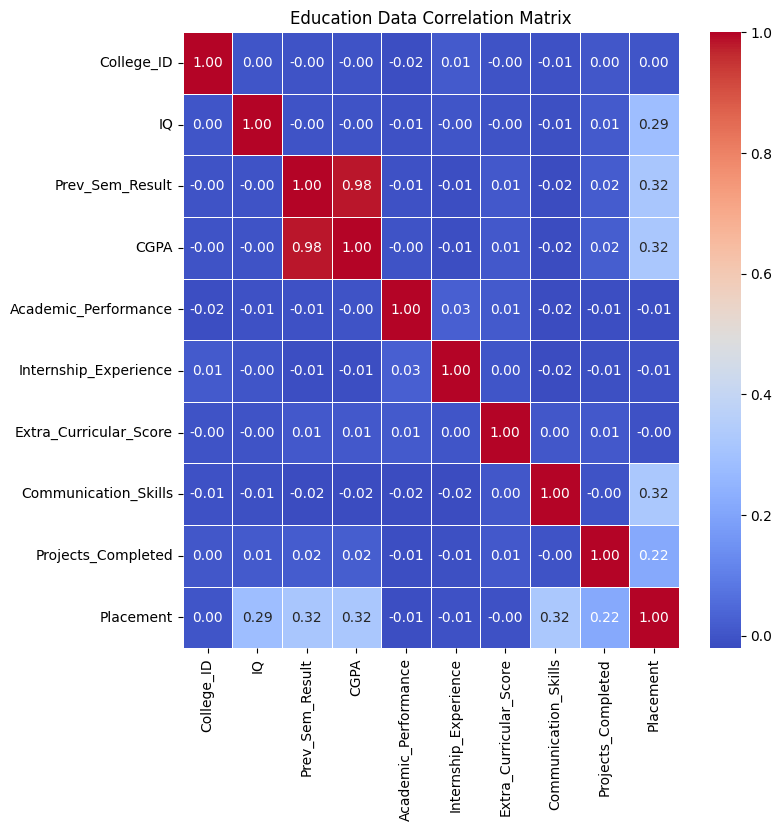

In [11]:
#Correlation matrix of all the variables to test for correlation and multicollinearity
matrix = df.corr()

plt.figure(figsize=(8,8))
sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Education Data Correlation Matrix')
plt.show()

From the correlation matrix, the features are not correlated with each other. This is a positive, as there isn't substantial multicollinearity. This means features are not dependant on each other which helps in fitting models as we have independent variables testing for the target. Additionally, the top correlation in the data for the target variable in order is the following:

1. Previous Semester Result, Cumulative Grade Point Average, Communication Skills (0.32).
2. IQ (0.29).
3. Projects Completed (0.22).

Furthermore, we can also see in this investigation the College ID has no impact on the outcome and therefore is redundant and will be removed from the dataset.

In [12]:
#Removing College_ID from the dataset

df = df.drop('College_ID', axis=1)
df.head()

,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Internship_Experience,Extra_Curricular_Score,Communication_Skills,Projects_Completed,Placement
0,107,6.61,6.28,8,0,8,8,4,0
1,97,5.52,5.37,8,0,7,8,0,0
2,109,5.36,5.83,9,0,3,1,1,0
3,122,5.47,5.75,6,1,1,6,1,0
4,96,7.91,7.69,7,0,8,10,2,0


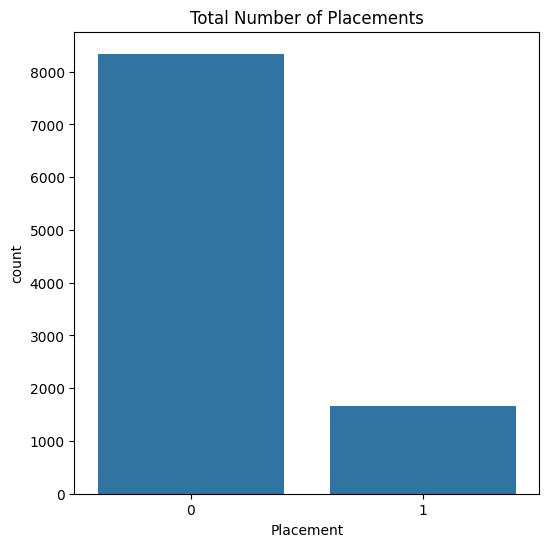

In [13]:
#Visualising the total number of placements

plt.figure(figsize=(6,6))
sns.countplot(x='Placement', data=df)
plt.title('Total Number of Placements')
plt.show()

As the figure shows, this dataset is imbalanced. There are more records for no placement than placement. This means that when the machine learning model is applied it could be biased as there is more training data for one class than the other. A potential way to mitigate this is to use a weighted loss function, for example ridge regression.

In [14]:
#To display the relationships of the most correlated variables, must find the mean of these variables in accordance with the placement

#Function to find the mean of a feature
def mean_value(df, feature):

  #The mean of the feature depending on the class of the placement
  mean_value = df.groupby('Placement')[feature].mean()
  return mean_value

#Mean values of the top correlated features
mean_comms = mean_value(df, 'Communication_Skills')
mean_pc = mean_value(df, 'Projects_Completed')
mean_cgpa = mean_value(df, 'CGPA')
mean_prev_sem = mean_value(df, 'Prev_Sem_Result')
mean_iq = mean_value(df, 'IQ')
mean_academ = mean_value(df, 'Academic_Performance')
mean_ecs = mean_value(df, 'Extra_Curricular_Score')

In [15]:
#Function to plot the bar chart

def plot_bar(mean_value):
  plt.figure(figsize=(6,6))
  sns.barplot(x=mean_value.index, y=mean_value.values)
  plt.title(f'Mean of {mean_value.name} in accordance with Placement')
  plt.xlabel('Placement')
  plt.ylabel(f'Mean of {mean_value.name}')
  return plt.show()

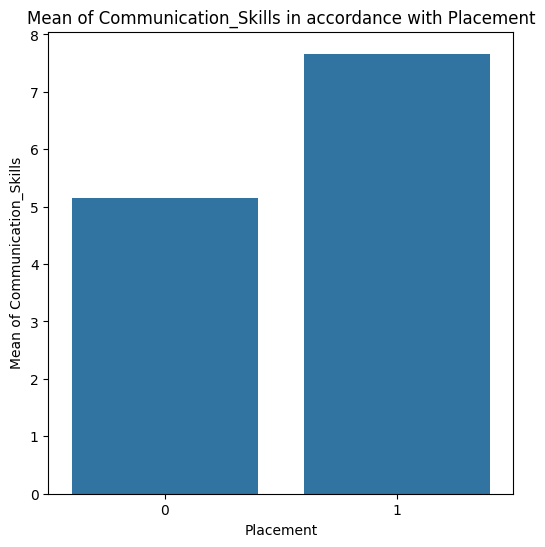

In [16]:
#Mean Communication skills according to Placement
plot_bar(mean_comms)

The figure indicates that there is a positive correlation for communication skills and placement. Since the mean was higher for placement, this suggests that students who achieved placement tended to have better communication skills

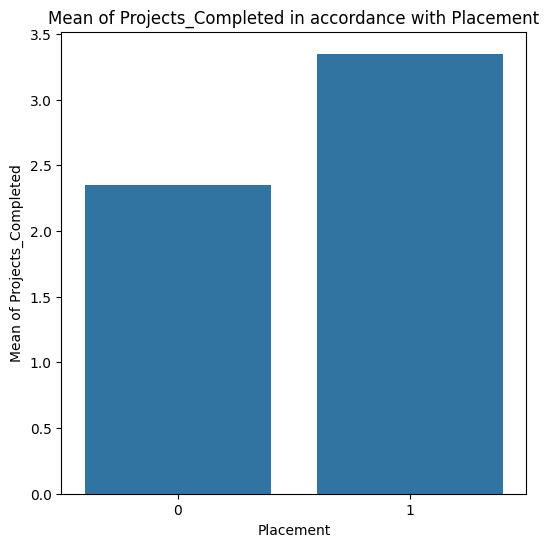

In [17]:
#Projects Compeleted according to Placement
plot_bar(mean_pc)

The figure displays a positive correlation. A student who has achieved a placement tends to complete more projects

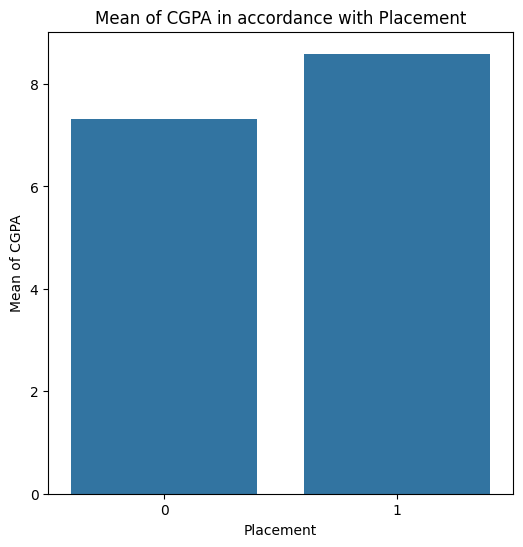

In [18]:
#Cumulative Grade Point Average according to Placement
plot_bar(mean_cgpa)

This figure also displays a somewhat positive correlation. Students tend to have a higher Cumulative Grade Point Average who have achieved placement. However, it is worth noting that the different in the averages between the classes of placement is small.

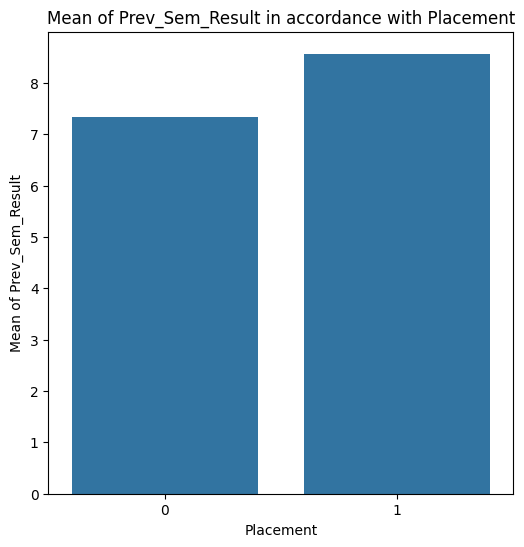

In [19]:
#Previous Semester Result according to Placement
plot_bar(mean_prev_sem)

This figure is similar to Cumulative Grade Point average. Whilst students tend to have a higher previous semester result who have had placement, the difference between the average previous semester result for those who have not achieved placement and those who have is small.

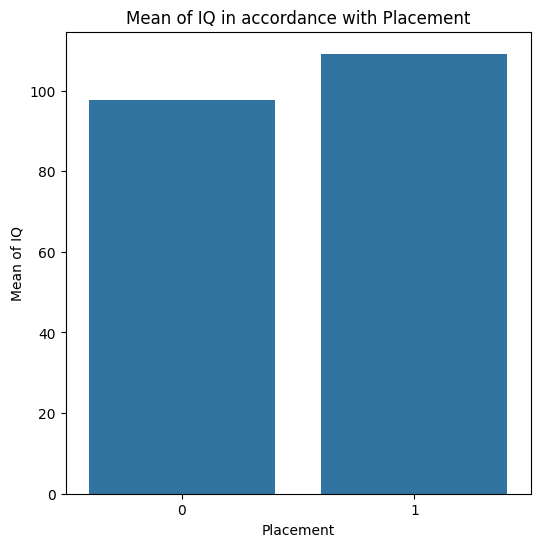

In [20]:
#IQ according to Placement
plot_bar(mean_iq)

Again, the results are similar to Cumulative Grade Point Average and Previous Semester Result

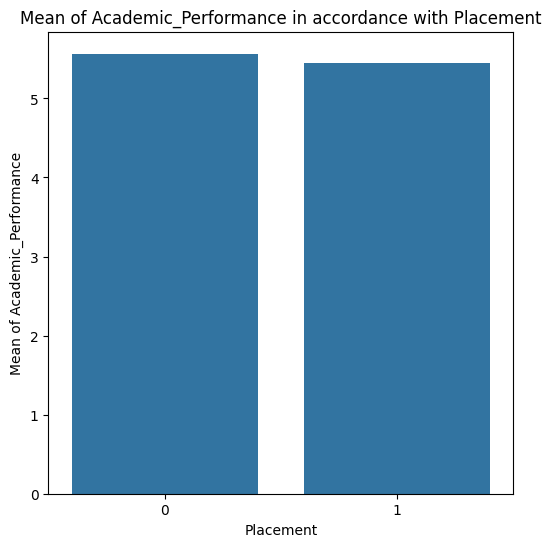

In [21]:
#Academic Performance according to Placement
plot_bar(mean_academ)

Unexpected result, even though the average academic performance is similar for placement and non-placement students, the average academic performance is higher for students who were not placed. This would suggest that placement is not only determined from an academic standpoint.

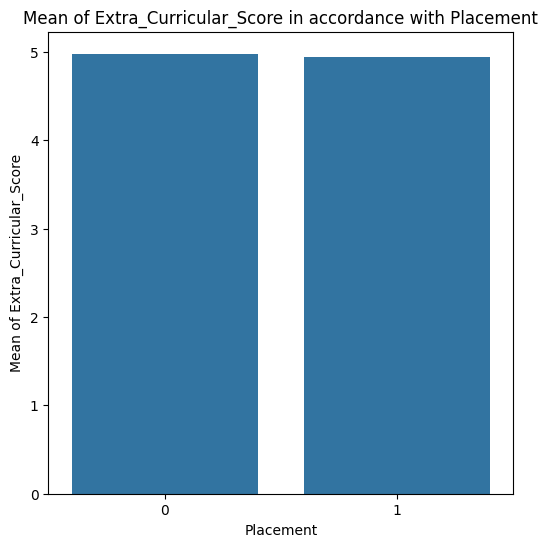

In [22]:
#Extra Curricular Score according to Placement
plot_bar(mean_ecs)

This figure produced similar results to Academic Performance. Whilst the average score is similar for both classes, it's higher for students who didn't achieve placement.

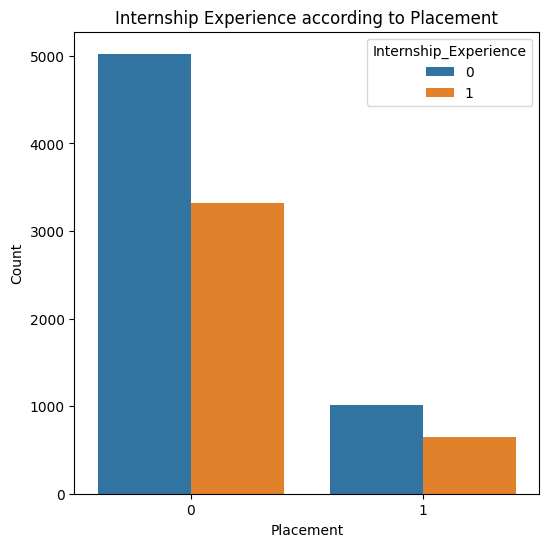

In [23]:
#Internship Experience according to Placement

#Finding the number of students who had internship experience and those who did not in both classes of placement
intern_placement = df.groupby('Placement')['Internship_Experience'].value_counts()

#Plotting bar chart
plt.figure(figsize=(6,6))
sns.barplot(x=intern_placement.index.get_level_values(0), y=intern_placement.values, hue=intern_placement.index.get_level_values(1))
plt.title('Internship Experience according to Placement')
plt.xlabel('Placement')
plt.ylabel('Count')
plt.show()

This figure displays a similar proportion of internship experience and non internship experience in both placement classes. On closer inspection, we can see that, of the students who achieved placement, the trend was higher for students who have internship experience.

##Training Model

In [24]:
#Splitting the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
#Standardising data
standard = StandardScaler()
X_train = standard.fit_transform(X_train)
X_test = standard.transform(X_test)

In [26]:
#SMOTE for the imbalance in data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

(GeeksforGeeks, 2025)

In [27]:
#Setting a dictionary to define mutiple models to be tested in gridsearch for hyperparameterisation
model_parameters = {

    #SVM model to be tested with multiple kernels as well
    'svm' : {
        'model' : SVC(),
        'parameters' : {
            'C' : [1, 10, 20],
            'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
            'gamma' : ['scale', 'auto']
        }
    },

    #Random Forest model
    'random_forest' : {
        'model' : RandomForestClassifier(),
        'parameters' : {
            'n_estimators' : [1, 5, 10, 15,]
        }
    },

    #Logistic Regression model
    'logisitic_regression' : {
        'model' : LogisticRegression(),
        'parameters' : {
            'C' : [1, 5, 10, 15],
            'solver' : ['liblinear', 'lbfgs', 'sag', 'saga']
          }
    },

    #Decision Tree model
    'decision_tree' : {
        'model' : DecisionTreeClassifier(),
        'parameters' : {
            'criterion' : ['gini', 'entropy', 'log_loss']
        }
    },

    #K-Nearest Neighbour
    'knn' : {
        'model' : KNeighborsClassifier(),
        'parameters' : {
            'n_neighbors' : [1, 5, 10, 15]
        }
    },

    #Ridge Regression
    'ridge' : {
        'model' : Ridge(),
        'parameters' : {
            'alpha' : [0.01, 0.1, 1, 10]
        }
    }
}

(codebasics, 2019)

In [28]:
#Fit the models and store the scores, best parameters, and best estimators into a list

#Empty list to append the information
model_scores = []

#For... Loop to fit the models into the training data using the dictionary of models and append the best score, best parameters, and the best estimators into the list
for model, parameters in model_parameters.items():
  grid_search = GridSearchCV(parameters['model'], parameters['parameters'], cv=5)
  grid_search.fit(X_train, y_train)
  model_scores.append({
      'model' : model,
      'best_score' : grid_search.best_score_,
      'best_parameters' : grid_search.best_params_,
      'best_estimator' : grid_search.best_estimator_
  })

##Testing and Evaluating the Model

(codebasics, 2019)

In [29]:
#Visualise the testing information

#Making the list into a dataframe for better visualisation and ordering it in best score order to determine the best model
best_model = pd.DataFrame(model_scores, columns=['model', 'best_score', 'best_parameters', 'best_estimator'])
best_model.sort_values('best_score', ascending=False)

,model,best_score,best_parameters,best_estimator
1,random_forest,0.998050,{'n_estimators': 5},"(DecisionTreeClassifier(max_features='sqrt', r..."
3,decision_tree,0.996250,{'criterion': 'gini'},DecisionTreeClassifier()
0,svm,0.978926,"{'C': 20, 'gamma': 'scale', 'kernel': 'rbf'}",SVC(C=20)
4,knn,0.964152,{'n_neighbors': 1},KNeighborsClassifier(n_neighbors=1)
2,logisitic_regression,0.865907,"{'C': 5, 'solver': 'liblinear'}","LogisticRegression(C=5, solver='liblinear')"
5,ridge,-0.025634,{'alpha': 10},Ridge(alpha=10)


(codebasics, 2019)

As the dataframe shows, the best performing model was the random forest classifier with 10 estimators. An earlier suggestion of ridge regression proved to be incorrect and the worst performer and therefore will not be tested any further.

### Decision Tree Classifier

In [30]:
#Function to display the confusion matrix for the models
def matrix_visual(model, Y_test, Y_pred):
  matrix = confusion_matrix(Y_test, Y_pred)
  plt.figure(figsize=(5,5))
  sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt='d', linewidths=0.5)
  plt.ylabel('Actual Result')
  plt.xlabel('Predicted Result')
  plt.title(f'{model} Confusion Matrix')
  return plt.show()

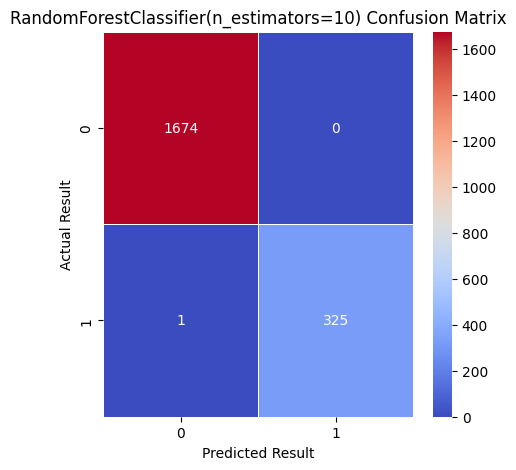

Training Accuracy: 0.9999250037498125
Test Accuracy: 0.9995


In [41]:
#Confusion matrix of random forest
modelRandomForest = RandomForestClassifier(n_estimators=10)
modelRandomForest.fit(X_train, y_train)

y_predict_rf = modelRandomForest.predict(X_test)

matrix_visual(modelRandomForest, y_test, y_predict_rf)

print(f'Training Accuracy: {modelRandomForest.score(X_train, y_train)}')
print(f'Test Accuracy: {modelRandomForest.score(X_test, y_test)}')

The model is the most accuract with only a single case of a false negative prediction. Although, this is extremely accurate this model is evident of overfitting.

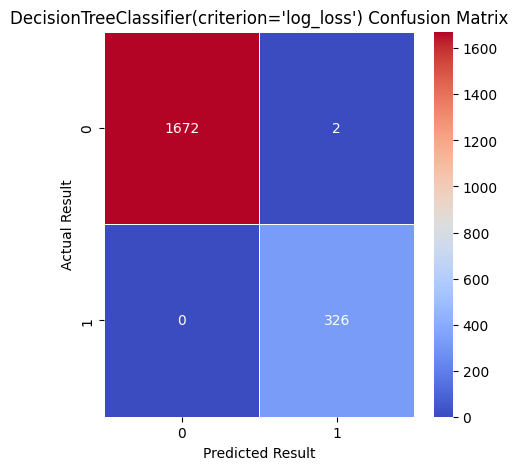

Training Accuracy: 1.0
Test Accuracy: 0.999


In [38]:
#Confusion matrix of decision tree with best parameters
modelDecisionTree = DecisionTreeClassifier(criterion='log_loss')
modelDecisionTree.fit(X_train, y_train)

y_predict_dt = modelDecisionTree.predict(X_test)

matrix_visual(modelDecisionTree, y_test, y_predict_dt)

print(f'Training Accuracy: {modelDecisionTree.score(X_train, y_train)}')
print(f'Test Accuracy: {modelDecisionTree.score(X_test, y_test)}')

Again extremely accurate indicating possible signs of overfitting especially with the 100% training accuracy. The issues this model had was false positives.

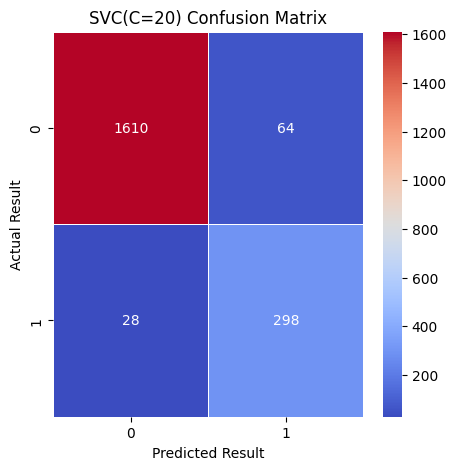

Training Accuracy: 0.9903254837258137
Test Accuracy: 0.954


In [39]:
#Confusion matrix of svm with best parameters
modelSVM = SVC(C=20, gamma='scale', kernel='rbf')
modelSVM.fit(X_train, y_train)

y_predict_svm = modelSVM.predict(X_test)

matrix_visual(modelSVM, y_test, y_predict_svm)

print(f'Training Accuracy: {modelSVM.score(X_train, y_train)}')
print(f'Test Accuracy: {modelSVM.score(X_test, y_test)}')

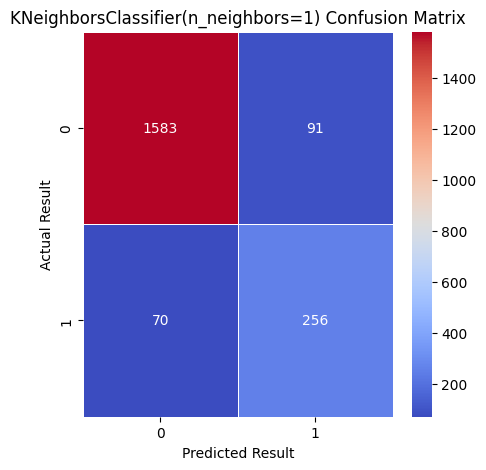

Training Accuracy: 1.0
Test Accuracy: 0.9195


In [42]:
#Confusion matrix of KNN with best parameters
modelKNN = KNeighborsClassifier(n_neighbors=1)
modelKNN.fit(X_train, y_train)

y_predict_knn = modelKNN.predict(X_test)

matrix_visual(modelKNN, y_test, y_predict_knn)

print(f'Training Accuracy: {modelKNN.score(X_train, y_train)}')
print(f'Test Accuracy: {modelKNN.score(X_test, y_test)}')

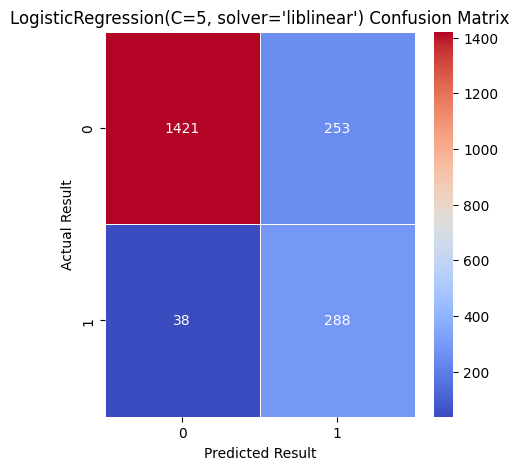

Training Accuracy: 0.8651567421628918
Test Accuracy: 0.8545


In [43]:
#Confusion matrix of logistic regression with best parameters
modelLogistic = LogisticRegression(C=5, solver='liblinear')
modelLogistic.fit(X_train, y_train)

y_predict_lr = modelLogistic.predict(X_test)

matrix_visual(modelLogistic, y_test, y_predict_lr)

print(f'Training Accuracy: {modelLogistic.score(X_train, y_train)}')
print(f'Test Accuracy: {modelLogistic.score(X_test, y_test)}')

##Conclusion

### Exploratory Data Analysis Summary

From the EDA, the results indicate that when it comes to the decision on a placement it will be a combination of practical skills and academic skills. This is because some of the academic features were positively correlated to placement such as IQ, Previous Semester Result, and Cumulative Grade Point Average. The reason to stand that it is not solely on academic performance is because Projects Completed (application skills) and Communication were positively correlated to placement whilst academic performance was actually negative correlated leaning towards non-placement.

### Machine Learning Model Summary

The dataset was imbalanced, as there were more non-placement datapoints than placement.

Overall the best performing models were random forest and decision tree. However, due to the high accuracy level and the the imbalance in the dataset the results could indicate the possible signs of overfitting.

The other models proved to be fairly accurate as well, although not as near as random forest and decision tree.

Additionally, most commonly across all models, when there were mistakes it tended to be false positive mistakes. This could suggest that because of the small dataset on placement, it could have led the models to be incorrectly predict a placement since there is not enough datapoints to train the models to understand the patterns and relationships for this class. Therefore, there would need to be more instances of real world placement instances to get a more accurate model for prediciting whether a student gets placed or not.

## References
codebasics. 2019. Machine Learning Tutorial Python - 16: Hyper parameter Tuning (GridSearchCV). [online]. Available from: https://www.youtube.com/watch?v=HdlDYng8g9s. Accessed: 15 August 2025.

GeeksforGeeks. 2025. ML | Handling Imbalanced Data with SMOTE and Near Miss Algorithm in Python. [online]. Available from: https://www.geeksforgeeks.org/machine-learning/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/. Accessed: 16 August 2025.

Islam, S. (2025, July). College Student Placement Factors Dataset. Retrieved 12 August 2025 from https://www.kaggle.com/datasets/sahilislam007/college-student-placement-factors-dataset?select=college_student_placement_dataset.csv.